In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [37]:
style.use('fivethirtyeight')

In [3]:
songs = pd.read_csv('./data/ten_genres_500_samp.csv')

In [4]:
X = songs._get_numeric_data().drop(columns=['key', 'mode'])
y = songs['genre']

In [20]:
def running_models(X, y, scaled=False, c=.65):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    
    # MODELING WITH SCALED FEATURES #
    
    # Scale the features
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    # Creating a df to display results
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model_sc = SVC(C=c, kernel='rbf', degree=3)
    model_sc.fit(X_train_sc, y_train)
    train_score = model_sc.score(X_train_sc, y_train)
    test_score = model_sc.score(X_test_sc, y_test)
    
    row = {'model': type(model_sc).__name__,
           'train_score' : train_score,
          'test_score' : test_score,
           'C': c,
          'scaled': True}
    model_df = model_df.append(row, ignore_index=True)
    
    # MODELING WITH UNSCALED FEATURES #
    
    model = SVC(C=20000, kernel='rbf', degree=3)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    row = {'model': type(model).__name__,
       'train_score' : train_score,
      'test_score' : test_score,
       'C': 20000,
      'scaled': False}
    model_df = model_df.append(row, ignore_index=True)
    return model_df

In [21]:
running_models(X, y)

,train_score,test_score,C,model,scaled
0,0.553867,0.5056,0.65,SVC,1.0
1,0.542933,0.4952,20000.00,SVC,0.0


For the 10-genre dataset, **Spotify's best accuracy is $\approx$ 50.6%**, this will be the baseline to compare my models against.

## Visualizing the results
Let's dig in and see what we can glean from the results of the predictions using Spotify's features

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [25]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [26]:
# .5056
model = SVC(C=.65, kernel='rbf')
cross_val_score(model, X_train_sc, y_train, n_jobs=12)

array([0.50266667, 0.51733333, 0.50533333, 0.49733333, 0.512     ])

The model has a decent cross validation score, **there don't seem to be any drastic blind spots**, as all the scores are within a 2% range.

In [30]:
model.fit(X_train_sc, y_train)

SVC(C=0.65)

In [28]:
y_preds = model.predict(X_test_sc)

In [29]:
results = X_test.copy()

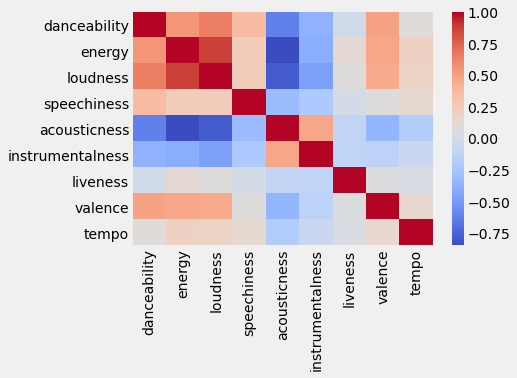

In [38]:
sns.heatmap(results.corr(), cmap='coolwarm');

There's a high **positive correlation between loudness and energy** and a high **negative correlation between energy and acousticness**

In [31]:
results.loc[:, 'genre'] = y_test.copy()

In [32]:
results.loc[:, 'preds'] = y_preds.copy()

In [33]:
results_wrong = results[results['genre'] != results['preds']]

In [43]:
results_wrong['genre'].value_counts(normalize=True)

pop                      0.173139
classical                0.155340
hip hop                  0.142395
r&b                      0.131068
rap                      0.113269
baroque                  0.077670
rock                     0.066343
tropical house           0.048544
serialism                0.046926
progressive bluegrass    0.045307
Name: genre, dtype: float64

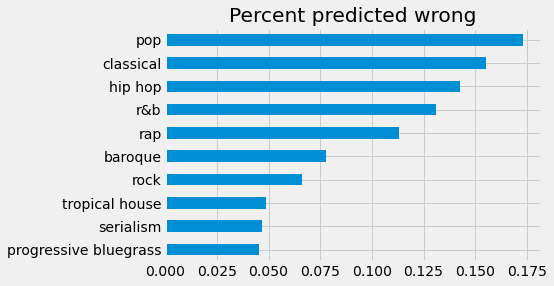

In [41]:
results_wrong['genre'].value_counts(normalize=True).sort_values().plot(kind='barh', title='Percent predicted wrong');

Pop and classical seem to be predicted wrong most often based on the features Spotify has pulled from the music.

In [36]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True)

hip hop                  0.414286
tropical house           0.185714
r&b                      0.185714
pop                      0.142857
rock                     0.057143
progressive bluegrass    0.014286
Name: preds, dtype: float64

It seems that when Rap is predicted wrong, it's predicted as R&B about 89.1% of the time

In [37]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True)

hip hop                  0.246914
rap                      0.234568
pop                      0.234568
rock                     0.135802
tropical house           0.086420
progressive bluegrass    0.049383
baroque                  0.012346
Name: preds, dtype: float64

R&B is most likely to be predicted as rap, but only 47.3% of the time.

In [38]:
genre_mean = songs.groupby('genre').mean()

Text(0.5, 1.0, 'Danceability by Genre')

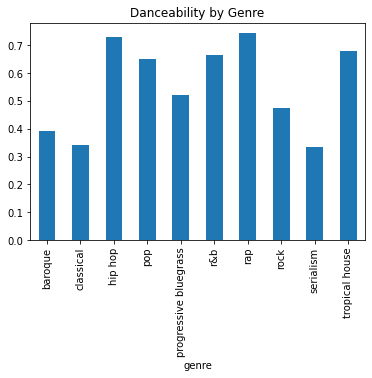

In [39]:
genre_mean['danceability'].plot(kind='bar');
plt.title('Danceability by Genre')

It looks like Rap has the highest danceability at over 0.7, Classical has the lowest danceability at just above 0.3.

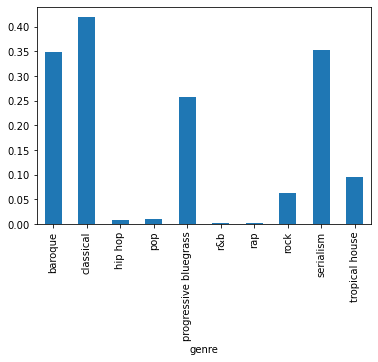

In [40]:
genre_mean['instrumentalness'].plot(kind='bar');

Classical has the highest instrumentalness, while rap has the lowest

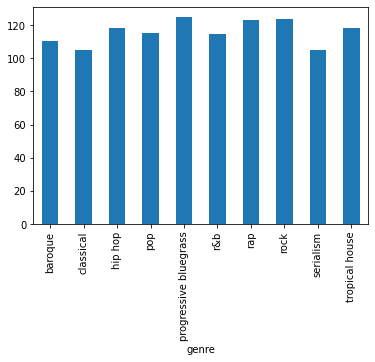

In [41]:
genre_mean['tempo'].plot(kind='bar');

Interesting that most of the genres hover slightly above 120 as a tempo. There's some interesting reasoning behind this with commercial music and the need for 30-seconds of music to fill an advertising slot. 128 beats per minute would allow for a 16-bar phrase in 4/4 time.

## What's next?

Now that I've seen how accurate models can be with the features that Spotify provides, I want to create/extract my own features from the audio I've pulled from Spotify.